In [59]:
using Random, Gadfly, Optim, Distributions, Distances, LinearAlgebra, ForwardDiff, Cairo

include("../iGMRF.jl");
include("../dataGen.jl");
include("../approxFramework.jl");
include("../plotting.jl");
include("optim.jl");

In [60]:
# Seed
Random.seed!(400)
# Dimensions de la grille
m₁ = 10;
m₂ = 10;
# Nb total de cellules
m = m₁ * m₂;
# Matrice de structure
κᵤ = 10.0;
F = iGMRF(m₁, m₂, κᵤ);
# Grille cible
grid_target = generateTargetGrid(F);
grid_target[:, :, 1] = grid_target[:, :, 1] .+ 10;
# Génération de données
nobs = 100;
Y = generateData(grid_target, nobs);

In [61]:
res = KLOptim(F, Y)

Temps pour trouver le mode : 10.569107709 s
Temps pour calculer l'info de Fisher : 2.576458541 s
Temps pour l'optimisation : 469.456642375 s


 * Status: success

 * Candidate solution
    Final objective value:     2.987669e+02

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 1.22e-10 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.12e-12 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.63e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.88e-14 ≰ 0.0e+00
    |g(x)|                 = 8.52e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   456  (vs limit Inf)
    Iterations:    59
    f(x) calls:    157
    ∇f(x) calls:   157
    ∇²f(x) calls:  59


## Analyse de l'approximation

### Visuelle

In [74]:
η̂ = Optim.minimizer(res)[1:m];
â = Optim.minimizer(res)[m+1]^2;
b̂ = Optim.minimizer(res)[m+2]^2;

Approx vs MCMC

In [69]:
include("../mcmc.jl");

niter = 100000
δ² = 0.2
κᵤ₀ = 10
μ₀ = zeros(m)

θ = gibbs(niter, Y, m₁=m₁, m₂=m₂, δ²=δ², κᵤ₀=κᵤ₀, μ₀=μ₀);

warming_size = Int(0.2 * niter);
θsampling = θ[warming_size:end, :, :];

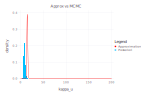

In [78]:
# Pour κᵤ

approxDensity(x::Real) = 1/x * pdf(Gamma(â, b̂), log(x))
a = 0;
step = 0.1;
b = 200;

plotApproxVSMCMC(
    approxDensity,
    θsampling.value[:, 1, 1],
    # "../plots/precision/approxvsmcmc_kappa.png",
    a=a,
    b=b,
    step=step;
    xLabel="kappa_u",
    yLabel="density",
)

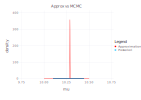

In [79]:
# Pour μ

σ̂ = sqrt(b̂ / (â - 1))

approxDensity(x::Real) = pdf(TDist(2*â), (x - η̂[1]) / σ̂) / σ̂;
a = 10.0;
b = 10.5;
step = .001;

plotApproxVSMCMC(
    approxDensity,
    θsampling.value[:, 2, 1],
    # "../plots/precision/approxvsmcmc_mu.png",
    a=a,
    b=b,
    step=step,
    xLabel="mu",
    yLabel="density",
)

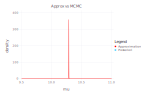

In [77]:
x = a:step:b;

plot(
    layer(x=x, y=approxDensity.(x), Geom.line, Theme(default_color="red")),
    # layer(x=MCMCsample, Geom.histogram(density=true)),
    Guide.manual_color_key("Legend", ["Approximation", "Posteriori"], ["red", "deepskyblue"]),
    Theme(background_color="white"),
    Guide.title("Approx vs MCMC"),
    Guide.xlabel("mu"),
    Guide.ylabel("density"),
)

In [73]:
â

4.0

In [62]:
mode = findMode(θ -> functionalFormPosterior(θ, F=F, Y=Y), [1, fill(0.0, m)...]);

α = Optim.minimizer(mode);
gap = Optim.minimum(mode);

Fvar = inv(computeFisherInformation(θ -> densityTarget(θ, gap, F=F, Y=Y), α));

calculationSpace = createCalculationSpace(α, Fvar, 1000);

η = α[2:end];
a = 2^2;
b = 10^2;

logDensityApprox(x::DenseVector) = logpdf(MvNormal(η, I/x[1]), x[2:m+1]) + logpdf(Gamma(a, b), x[1]);

# Évaluation des densités
p = vec(mapslices(x -> densityTarget(x, gap, F=F, Y=Y), calculationSpace, dims=1));
q = vec(mapslices(x -> logDensityApprox(x), calculationSpace, dims=1));

kldiv(p, q)

436.0634726747623

In [63]:
gap

15721.867962363418

In [64]:
densityTarget(α, gap, F=F, Y=Y)

0.0

In [65]:
α

101-element Vector{Float64}:
  2.697995358909713
 10.28663407360228
 10.400889264275689
 10.1946476248634
 10.355637378295631
 10.308260271804746
 10.269417114710182
 10.290741004755755
 10.020163460990162
 10.088250450945193
  ⋮
 10.07847173907532
  9.941269308993261
  9.741373515518667
  9.531674400613378
  9.701700996695903
  9.802762945935042
  9.699645339758025
  9.591986997164243
  9.365951318234051

In [66]:
calculationSpace

101×1000 Matrix{Float64}:
  2.57856   2.66209   2.73704   2.70127  …   2.66941   2.65845   2.67121
 10.2814   10.3204   10.3347   10.3105      10.2667   10.3265   10.2981
 10.3819   10.4223   10.3938   10.4449      10.3486   10.3597   10.3844
 10.1593   10.1688   10.2336   10.2629      10.1787   10.2177   10.1688
 10.3461   10.3435   10.3211   10.3553      10.3589   10.3451   10.3856
 10.3132   10.3236   10.3407   10.274    …  10.3072   10.3347   10.2998
 10.2771   10.2899   10.2695   10.2417      10.2618   10.2786   10.3055
 10.3163   10.3129   10.3024   10.3441      10.316    10.3503   10.3196
 10.0384   10.0303   10.0594   10.0302      10.0561   10.0474   10.0194
 10.0744   10.1128   10.0507   10.0754      10.1065   10.0707   10.1185
  ⋮                                      ⋱                      
 10.0213   10.1063   10.0836   10.0494      10.0841   10.1219   10.039
  9.9248    9.94118   9.92432   9.91206     10.0027    9.94585   9.88041
  9.72118   9.78729   9.73941   9.75608     

In [67]:
vec(mapslices(x -> densityTarget(x, gap, F=F, Y=Y), calculationSpace, dims=1))

1000-element Vector{Float64}:
 -5.086518309582971
 -4.986426180947092
 -5.585060260633327
 -4.185921210444576
 -5.078452572637616
 -6.256587570504053
 -3.7795427896380716
 -4.257202497557955
 -4.294165457478812
 -4.445139714896868
  ⋮
 -4.78002991347239
 -6.4260288148161635
 -4.267190796465002
 -5.430299138697592
 -6.503220400431019
 -5.17681707101292
 -4.735061798010065
 -4.933529398249448
 -4.428115867542147

In [68]:
exp.(vec(mapslices(x -> densityTarget(x, gap, F=F, Y=Y), calculationSpace, dims=1)))

1000-element Vector{Float64}:
 0.006179497573629153
 0.0068300302190763785
 0.003753523573247225
 0.015208189543829766
 0.006229541324071891
 0.0019177789287497587
 0.02283312858190593
 0.014161864897920345
 0.01364795674619916
 0.011735466296934123
 ⋮
 0.008395747817764572
 0.0016188669066236133
 0.014021116049186568
 0.004381784845187776
 0.001498605304458511
 0.0056459484982015916
 0.008781906110669315
 0.007201043029458935
 0.011936959310740812